In [91]:
## Basic data, math, draw modules
import pandas as pd
import numpy as np
from numpy import inf
from enum import Enum 
import matplotlib.pyplot as plt

## Machine learning methods modules
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Stastic and evaluate model modules
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split


## Read the training data and testing data
training_data = './training_data.csv'
test_data = './songs_to_classify.csv'
data = pd.read_csv(training_data)
test_data = pd.read_csv(test_data)

In [92]:


## To declare the types of model
class models(Enum):
    LR =  "LR"
    KNN = "KNN"
    QDA = "QDA"
    LDA = "LDA"
    ADA = "ADA"
    RF =  "RF"


## The function is used for selecting the model.  
## "arg" name of model selection, 
## "arg1" is to set the corresponding parameter
def model_selection(arg,arg1):
    if arg=="KNN":
        model=skl_nb.KNeighborsClassifier(n_neighbors=arg1)
    if arg=="LR":
        # tol: Tolerance for stopping criteria. 
        model=skl_lm.LogisticRegression(C=arg1,tol=1e-5)
    if arg=="QDA":
        model=skl_da.QuadraticDiscriminantAnalysis()
    if arg=="LDA":
        model = skl_da.LinearDiscriminantAnalysis()
    if arg=="ADA":
        # refer from the lecture notes chapter 6
        # we tried from 4-13, and the best result jump between 5 to 8
        # we preliminary set as 6.
        tree=DecisionTreeClassifier(max_depth=6)
        model=AdaBoostClassifier(base_estimator=tree, \
                                 n_estimators=arg1)
    if arg=="RF":
        model=RandomForestClassifier(n_estimators=arg1, random_state=7)
        
    model.fit(X_train,y_train)
    
    return model

## To implement 5,7,10-fold cross validation to get the accuracy. 
## "model" used to set the type of the model
## "X_train,y_train" input the training data and training data label.
## "argprint"  to print out the accuary result or not.
def own_crossvalidation(model,X_train,y_train,argprint):
    scores10=cross_validation.cross_val_score(model, X_train,y_train, cv=10)
    
    scores7=cross_validation.cross_val_score(model, X_train,y_train, cv=7)
    
    scores5=cross_validation.cross_val_score(model, X_train,y_train, cv=5)
    
    if argprint==1:
        print("10-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"  \
               % (scores10.mean(), scores10.std() * 2))
        print("7-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)" \
               % (scores7.mean(), scores7.std() * 2))
        print("5-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)" \
               % (scores5.mean(), scores5.std() * 2))
    
    return (scores7.mean()+scores5.mean()+scores10.mean())/3 # return validation reuslt to tuning the parameters


##  To evaluate the selected models by validation set and whole dataset
## "model" used to set the type of the model
def model_evaluation(model):
    prediction = model.predict(X_test)
    # use the whole dataset to evaluate
    own_crossvalidation(model, data.loc[:,selected_predictor],data['label'],1)
    print (' Test data accuracy：',model.score(X_test,y_test))

    
##  The function is to draw graph.    
## "xrange" is data of x-axis. "yrange" is corresponding data of y-axis.
## "pointx, pointy"  draw a dot in the graph.
def plot(xrange,yrange,pointx, pointy):
    plt.plot(pointx, pointy,'ro')
    plt.plot(xrange, yrange)
    plt.title('Accuracy for model')
    plt.xlabel('parameter')
    plt.ylabel('Accuracy')
    plt.show()

    
##  To transform the data.    
## "data, test_data" input the the data and test data we want to transfrom.
## "arg" to set the predictor we want to transform
def data_transform(data,test_data,arg):
    if arg=="acousticness":
        data['acousticness']=np.log(data['acousticness'])
        test_data['acousticness']=np.log(test_data['acousticness'])
    if arg=="instrumentalness":
        data["instrumentalness"]=np.log(data["instrumentalness"])
        data["instrumentalness"]=data["instrumentalness"].replace(-inf, -20)
        test_data['instrumentalness']=np.log(test_data['instrumentalness'])
        test_data['instrumentalness']=test_data['instrumentalness'].replace(-inf, -20)
    if arg=="speechiness":
        data['speechiness']=np.log(data['speechiness'])
        test_data['speechiness']=np.log(test_data['speechiness'])
    
    return data,test_data

##  To clean the data.    
## "data, test_data" input the the data and test data we want to transfrom.
## "arg" to set the predictor we want to clean
def data_clean(data,test_data,arg):
    selected_predictor = ['acousticness','danceability','duration', \
                           'energy','instrumentalness','key','liveness', \
                          'loudness','mode','speechiness','tempo', \
                          'time_signature','valence']
    
    if arg=="speechiness":
        data=data.where(data['speechiness']<0.66).dropna()
    if  arg=="duration":
        data=data.where((data['duration']>=1*60*1000) \
                        & (data['duration']<=7*60*1000)).dropna()
    if  arg=="mode":
        selected_predictor = ['acousticness','danceability', \
                              'duration','energy','instrumentalness', \
                              'key','liveness','loudness','speechiness', \
                              'tempo','time_signature','valence']
    
    return data,test_data,selected_predictor   

In [93]:
## Data cleaning and transformed
## Drop transform function to get the performance of origianl data
data,test_data=data_transform(data,test_data,"acousticness")
data,test_data=data_transform(data,test_data,"instrumentalness")
data,test_data=data_transform(data,test_data,"speechiness")
data,test_data,selected_predictor=data_clean(data,test_data,"speechiness")
data,test_data,selected_predictor=data_clean(data,test_data,"duration")
data,test_data,selected_predictor=data_clean(data,test_data,"mode")

  # split the whole training set into training set 80%, validation set 20% 
X_train,X_test,y_train,y_test = train_test_split \
            (data.loc[:,selected_predictor],data['label'], \
             test_size=0.2, random_state = 0)
  # the data without labeled, used for final solution
final_test=test_data.loc[:,selected_predictor]

/home/billy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log
/home/billy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log


best K is  9


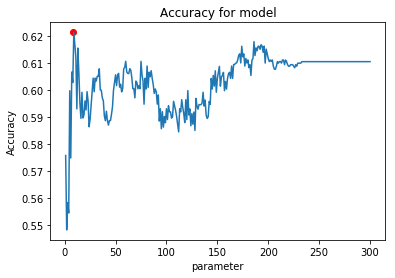

In [87]:
# KNN Tune

# used to score the model accuracy in the process of training
clas_sco = []

## Tune the parameter k -number of neighbors

for k in range(300): 
    model=model_selection(models.KNN.value,k+1)
    clas_sco.append(own_crossvalidation(model,X_train,y_train,None))
    
K = np.linspace(1, 300, 300)
# the list index begin wiht 0, our variable begin with 1.
print('best K is ', clas_sco.index(max(clas_sco))+1)
plot(K,clas_sco,clas_sco.index \
         (max(clas_sco)),clas_sco[clas_sco.index(max(clas_sco))])

In [ ]:
# LR Tune

clas_sco = []

## Tune the parameter C -inverse of regularization strength

ParaC=0.1
for k in range(50):
    model=model_selection(models.LR.value,ParaC)
    clas_sco.append(own_crossvalidation(model,X_train,y_train,None))
    ParaC=ParaC+0.1
    
K = np.linspace(0.1, 5, 50)
print('best C is ', 0.1*(clas_sco.index(max(clas_sco))+1))
plot(K,clas_sco,0.1*clas_sco.index \
         (max(clas_sco))+0.1,clas_sco[clas_sco.index(max(clas_sco))])

In [ ]:
# Tune RF

clas_sco = []

## Tune the parameter 
## n_estimator-The number of trees in the forest.
c=10
for k in range(30):
    model=model_selection(models.RF.value,c)
    clas_sco.append(own_crossvalidation(model,X_train,y_train,None))
    c=c+10
    
K = np.linspace(10, 300, 30)
print('best estimators is ', 10*(clas_sco.index(max(clas_sco))+1))
plot(K,clas_sco,10*clas_sco.index(max(clas_sco))+10, \
         clas_sco[clas_sco.index(max(clas_sco))])

best estimators is  1400


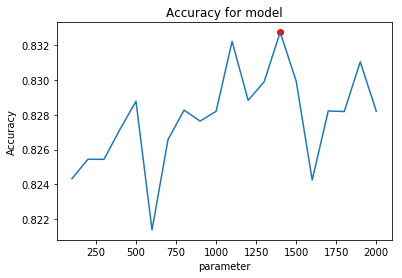

In [88]:
## Tune ADA

clas_sco = []

## Tune the parameter n_estimator
## n_estimator -The maximum number of estimators at which boosting is terminated. 

c=100
for k in range(20):
    model=model_selection(models.ADA.value,c)  
    clas_sco.append(own_crossvalidation(model,X_train,y_train,None))
    c=c+100

K = np.linspace(100, 2000, 20)
print('best estimators is ', 100*(clas_sco.index(max(clas_sco))+1))
plot(K,clas_sco,100*clas_sco.index(max(clas_sco))+100, \
         clas_sco[clas_sco.index(max(clas_sco))])


best estimators is  5


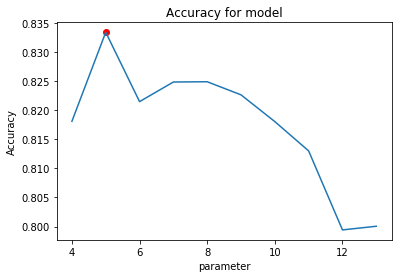

In [98]:
## Tune depth

clas_sco = []

## Tune the parameter max_depth-number of max depth of tree

c=4
for k in range(10):
    tree=DecisionTreeClassifier(max_depth=c)
    model=AdaBoostClassifier(base_estimator=tree,n_estimators=100)
    clas_sco.append(own_crossvalidation(model,X_train,y_train,None))
    c=c+1

K = np.linspace(4, 13, 10)
print('best estimators is ', 1*(clas_sco.index(max(clas_sco))+4))
plot(K,clas_sco,1*clas_sco.index(max(clas_sco))+4, \
         clas_sco[clas_sco.index(max(clas_sco))])

In [100]:
## Use whole training dataset to test the performance of each model
## Evaluated by k-fold crossvalidation
## All LIKE is to output all "1" to check the accuracy

# All LIKE
print("ALL LIKE")
print(' Test data accuracy：',accuracy_score \
      (data['label'],np.full([len(data['label']),1], 1)))


# KNN
print("KNN")
model=model_selection(models.KNN.value,9)
model_evaluation(model)

# LR
print("LR")
model=model_selection(models.LR.value,1.6) 
model_evaluation(model)

# LDA
print("LDA")
model=model_selection(models.LDA.value,None)
model_evaluation(model)

# QDA
print("QDA")
model=model_selection(models.QDA.value,None)
model_evaluation(model)

# RF
print("RF")
model=model_selection(models.RF.value,200)
model_evaluation(model)

# ADA
print("ADA")
model=model_selection(models.ADA.value,1400)#1400#700
model_evaluation(model)

## Output the final soltion by RF
print (model.predict(final_test))

ALL LIKE
 Test data accuracy： 0.6032608695652174
KNN
10-fold Cross Validation Accuracy: 0.57 (+/- 0.11)
7-fold Cross Validation Accuracy: 0.57 (+/- 0.08)
5-fold Cross Validation Accuracy: 0.56 (+/- 0.07)
 Test data accuracy： 0.5743243243243243
LR
10-fold Cross Validation Accuracy: 0.80 (+/- 0.07)
7-fold Cross Validation Accuracy: 0.79 (+/- 0.06)
5-fold Cross Validation Accuracy: 0.79 (+/- 0.04)
 Test data accuracy： 0.8040540540540541
LDA
10-fold Cross Validation Accuracy: 0.80 (+/- 0.08)
7-fold Cross Validation Accuracy: 0.80 (+/- 0.04)
5-fold Cross Validation Accuracy: 0.81 (+/- 0.06)
 Test data accuracy： 0.7702702702702703
QDA
10-fold Cross Validation Accuracy: 0.79 (+/- 0.10)
7-fold Cross Validation Accuracy: 0.79 (+/- 0.06)
5-fold Cross Validation Accuracy: 0.77 (+/- 0.04)
 Test data accuracy： 0.7094594594594594
RF
10-fold Cross Validation Accuracy: 0.84 (+/- 0.07)
7-fold Cross Validation Accuracy: 0.84 (+/- 0.05)
5-fold Cross Validation Accuracy: 0.85 (+/- 0.03)
 Test data accurac